In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')
from models.WGAN_model.WPGAN_GP import WPGAN_GP
from models.WGAN_model.config import *


C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
Music_WPGAN = WPGAN_GP(
    latent_dim=latent_dim,
    output_dim=output_dim,
    lr=learning_rate,
    loss=loss,
    batch_size=batch_size,
    gpu=gpu,
    depths=depths, 
    negative_slope=negative_slope,
    fade_in_percentage=fade_in_percentage,
    save_interval=save_interval,
    normalization=normalization,
    mini_batch_normalization=mini_batch_normalization,
    epsilon_D=epsilon_D,
    gen_type=get_type,
    init_resolution_size=init_resolution_size,
    num_epochs_per_resolution=num_epochs_per_resolution,
    gen_output_dim=gen_output_dim,
    c=c,
    n_critic=n_critic,
    acgan=acgan,
    feature_size=feature_size,
    features_keys_order = features_keys_order
)

In [4]:
# pretrained_path = './../models/saved_models/WPGAN/WPGAN-GP-single-best3'
pretrained_path = './../models/saved_models/WPGAN/WPGAN-GP-acgan-best1'
Music_WPGAN.load_pretrained_model(pretrained_path, load_optimizers=True)

Model loaded from ./../models/saved_models/WPGAN/WPGAN-GP-acgan-best1


In [5]:
import torch
import librosa

def generate(n_samples=1):
    Music_WPGAN.generator.eval()

    z = torch.randn(1, Music_WPGAN.latent_dim, 1, 1).to(Music_WPGAN.device)
    generated_spectrogram = Music_WPGAN.generator(z)

    spectrogram = generated_spectrogram.cpu().detach()
    spectrogram = spectrogram.squeeze()

    return spectrogram

In [35]:
def generate_with_condition(n_samples=1):
    Music_WPGAN.generator.eval()

    z = torch.randn(1, Music_WPGAN.latent_dim, 1, 1).to(Music_WPGAN.device)
    if Music_WPGAN.acgan:
        bass_feature_vector = torch.zeros(1, 11)
        bass_indices = [0]
        bass_feature_vector[0, bass_indices] = 1
        bass_feature_vector = bass_feature_vector.view(1, 11, 1, 1).to(Music_WPGAN.device)
        random_feature_vector = Music_WPGAN.classification_criterion.create_random_feature_vectors(b_size=1)
        random_feature_vector = random_feature_vector.view(1, -1, 1, 1).to(Music_WPGAN.device)
        z = torch.cat((z, bass_feature_vector), dim=1)
    generated_spectrogram = Music_WPGAN.generator(z)

    spectrogram = generated_spectrogram.cpu().detach()
    spectrogram = spectrogram.squeeze()

    return spectrogram

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram(spectrogram):
    fig, ax = plt.subplots()

    S_dB = librosa.amplitude_to_db(spectrogram, ref=np.min)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=16000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='WGAN-GP generated mel-spectrogram')

In [8]:
def get_audio_from_melspectrogram(melspectrogram):
    melspectrogram = melspectrogram[:, :126].numpy()
    audio = librosa.feature.inverse.mel_to_audio(
        M=melspectrogram,
        sr=16000,
        n_fft=2048,
        hop_length=512,
        win_length=2048,
    )
    return audio

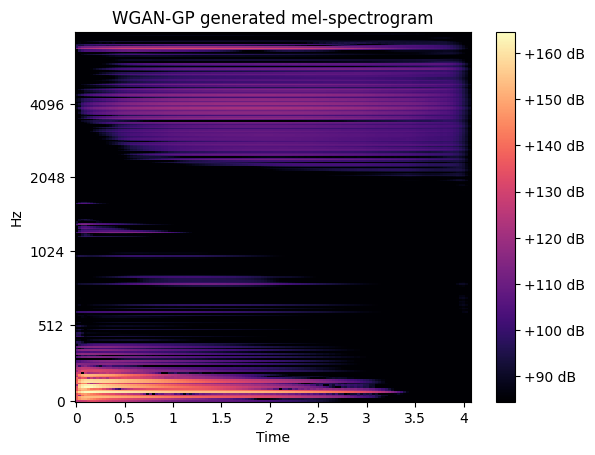

In [58]:
spectrogram = generate_with_condition(1)
plot_spectrogram(spectrogram)

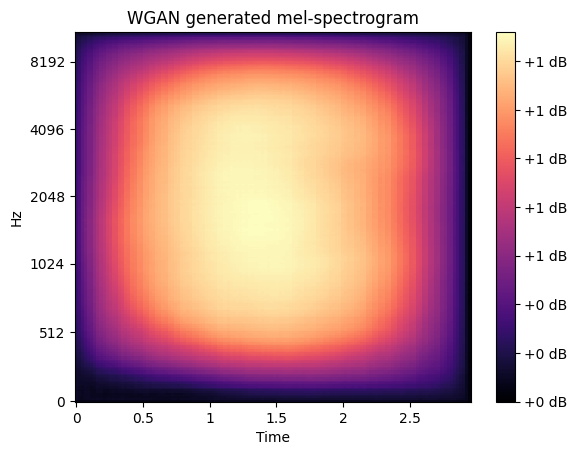

In [19]:
spectrogram = generate(n_samples=1)

In [17]:
audio = get_audio_from_melspectrogram(spectrogram)

In [18]:
import IPython.display as ipd

ipd.Audio(audio, rate=16000)